In [29]:
import json
import os
from pprint import pprint
import boto3
from pandas.io.json import json_normalize
import pandas as pd
import time
import sagemaker
from sagemaker import get_execution_role

bucket = 'yelpadsproject'
folder = 'data'

# get the region (pay attention to the region of your S3, SageMaker ... keep them in same region where possible)
region = boto3.Session().region_name

# create the s3 client
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'data/yelp_academic_dataset_review_8K.json')
file_content = obj['Body'].read().decode('ISO-8859-1') 

prefix = "BlazeOutput"
ts = str(int(time.time()))

filenameString = "blaze_" + ts + ".txt"
                          
dirfilename = "BlazeOutput/"+ filenameString

text_file = open(dirfilename, "w")

for kv in file_content.split("\n"):
    json_content = json.loads(kv)
    
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    
    sent_text = json_content['text']
    
    # remove punctuation from the string
    no_punct = ""
    for char in sent_text:
       if char not in punctuations:
           no_punct = no_punct + char
            
    text_file.write(no_punct)

    # display the unpunctuated string
   

text_file.close()

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, filenameString)).upload_file(dirfilename)
print("File Created="+dirfilename)

File Created=BlazeOutput/blaze_1538518100.txt


In [30]:
role = get_execution_role()
sess = sagemaker.Session()


prefix = 'output'
train_channel = prefix 

s3_train_data = 's3://{}/{}/'.format(bucket, train_channel)
print(s3_train_data)
s3_output_location = 's3://{}/{}/'.format(bucket, prefix)
print(s3_output_location)

container = sagemaker.amazon.amazon_estimator.get_image_uri(region, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region))

bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

s3_train_data = 's3://{}/{}/'.format(bucket, train_channel)
print(s3_train_data)
s3_output_location = 's3://{}/{}/'.format(bucket, prefix)
print(s3_output_location)

train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}




s3://yelpadsproject/output/
s3://yelpadsproject/output/
Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)
s3://yelpadsproject/output/
s3://yelpadsproject/output/


In [31]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2018-10-03-13-36-44-376


2018-10-03 13:36:44 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training......
2018-10-03 13:39:03 Downloading - Downloading input data
2018-10-03 13:39:11 Training - Training image download completed. Training in progress..
Arguments: train
Found 10.32.0.4 for host algo-1
Found 10.40.0.3 for host algo-2
Arguments: train
Found 10.32.0.4 for host algo-1
Found 10.40.0.3 for host algo-2
[10/03/2018 13:39:28 WARNING 140330515232576] Loggers have already been setup.
[10/03/2018 13:39:28 WARNING 140330515232576] Loggers have already been setup.
[10/03/2018 13:39:28 WARNING 140224229590848] Loggers have already been setup.
[10/03/2018 13:39:28 WARNING 140224229590848] Loggers have already been setup.
[10/03/2018 13:39:28 INFO 140224229590848] nvidia-smi took: 0.0251650810242 secs to identify 0 gpus
[10/03/2018 13:39:28 INFO 140224229590848] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[10/03/2018 1

In [38]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2018-10-03-13-45-45-965
INFO:sagemaker:Creating endpoint with name blazingtext-2018-10-03-13-36-44-376


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:684159701276:endpoint/blazingtext-2018-10-03-13-36-44-376".

In [37]:
words = ["shit", "DELICIOUS"]

payload = {"instances" : words}

print(payload)

response = bt_endpoint.predict(json.dumps(payload))

print(response)
vecs = json.loads(response)
print(vecs)

{'instances': ['shit', 'DELICIOUS']}
b'[{"vector": [0.10157692432403564, 0.16101819276809692, 0.05914321541786194, 0.042354293167591095, 0.07744734734296799, 0.16382554173469543, -0.10730700194835663, 0.08367044478654861, 0.07783591747283936, 0.06819349527359009, -0.08985862135887146, 0.20611101388931274, -0.18688267469406128, 0.09179487824440002, -0.08948301523923874, 0.13449238240718842, -0.061378445476293564, 0.002248581498861313, 0.014028210192918777, 0.040004123002290726, -0.06580454111099243, 0.1874110996723175, 0.059278104454278946, -0.010030246339738369, -0.11083275079727173, -0.08491773903369904, 0.3167102336883545, 0.028451062738895416, -0.11761195957660675, 0.21283438801765442, 0.006032564211636782, 0.04687708243727684, -0.10702886432409286, -0.15843647718429565, -0.10634592175483704, -0.01902296021580696, 0.024028167128562927, -0.015326115302741528, -0.14521262049674988, -0.12304441630840302, -0.028070971369743347, -0.02674786001443863, -0.04542594030499458, 0.1775079667568

In [40]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
print(key)

s3.Bucket(bucket).download_file(key, 'model.tar.gz')

output/blazingtext-2018-10-03-13-36-44-376/output/model.tar.gz


In [41]:
!tar -xvzf model.tar.gz

vectors.txt
eval.json
vectors.bin


In [42]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

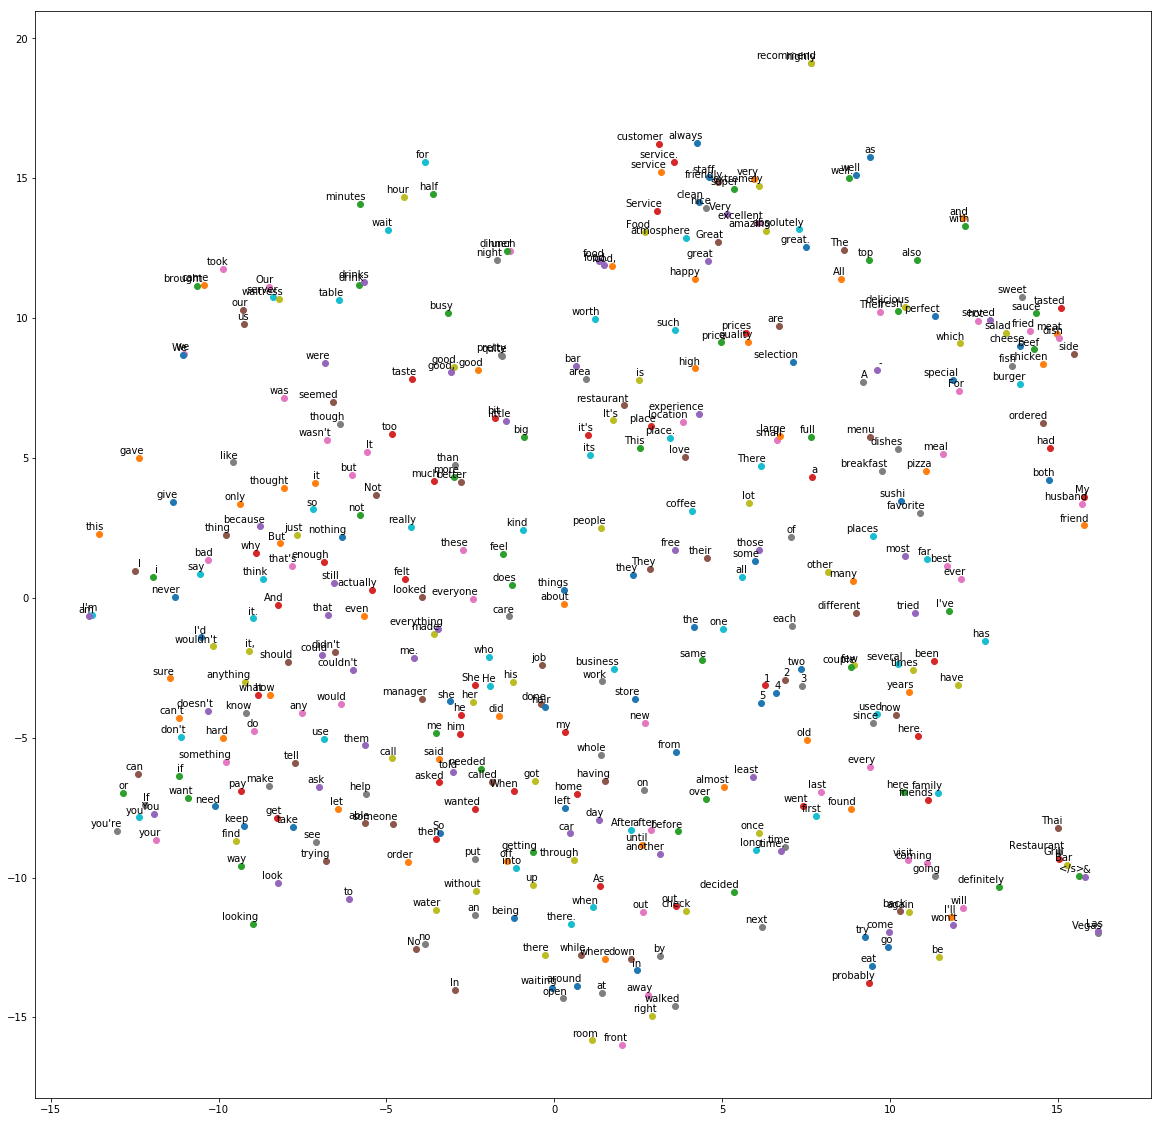

In [44]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)